In [2]:
import pickle
import bz2
with bz2.BZ2File('recursos/vectores_w2v_250_epochs.pkl.bz2', 'rb') as f:
    vectores_documentos = pickle.load(f)
with open('recursos/resultados_modelos.pkl', 'rb') as archivo:
    resultados = pickle.load(archivo)
with open('recursos/documents.pkl', 'rb') as archivo:
    documents = pickle.load(archivo)
    
etiquetas_predichas=resultados["gsdmm_100"]['etiquetas_predichas'][3]

In [3]:
import numpy as np
import hdbscan
from collections import defaultdict

# Paso 1: Agrupar vectores de documentos por clúster original
vectores_por_cluster = defaultdict(list)

for vector_doc, cluster_id in zip(vectores_documentos, etiquetas_predichas):
    vectores_por_cluster[cluster_id].append(vector_doc)

# Paso 2: Calcular vector promedio por clúster
vector_clusters = {
    cluster_id: np.mean(vectores, axis=0)
    for cluster_id, vectores in vectores_por_cluster.items()
}

# Paso 3: Aplicar HDBSCAN sobre los vectores de los clústeres
X_cluster_vectors = np.array(list(vector_clusters.values()))
cluster_ids_originales = list(vector_clusters.keys())
hdb = hdbscan.HDBSCAN(min_cluster_size=2,min_samples=1)
etiquetas_meta_cluster = hdb.fit_predict(X_cluster_vectors)

# Paso 4: Mapear resultados a los IDs originales de clúster
resultado_meta_cluster = dict(zip(cluster_ids_originales, etiquetas_meta_cluster))

# Resultado: para cada clúster original, su meta-clúster asignado
for cluster_id, meta_id in resultado_meta_cluster.items():
    print(f"Clúster original {cluster_id} → Meta-clúster {meta_id}")

Clúster original 44 → Meta-clúster 1
Clúster original 60 → Meta-clúster 7
Clúster original 1 → Meta-clúster 7
Clúster original 28 → Meta-clúster 8
Clúster original 41 → Meta-clúster 0
Clúster original 48 → Meta-clúster 0
Clúster original 14 → Meta-clúster 5
Clúster original 29 → Meta-clúster -1
Clúster original 6 → Meta-clúster -1
Clúster original 50 → Meta-clúster 2
Clúster original 13 → Meta-clúster -1
Clúster original 3 → Meta-clúster 3
Clúster original 22 → Meta-clúster 4
Clúster original 7 → Meta-clúster -1
Clúster original 45 → Meta-clúster -1
Clúster original 26 → Meta-clúster -1
Clúster original 30 → Meta-clúster 3
Clúster original 21 → Meta-clúster 6
Clúster original 53 → Meta-clúster 7
Clúster original 33 → Meta-clúster 2
Clúster original 24 → Meta-clúster 7
Clúster original 2 → Meta-clúster 6
Clúster original 36 → Meta-clúster -1
Clúster original 5 → Meta-clúster 6
Clúster original 4 → Meta-clúster 2
Clúster original 54 → Meta-clúster 6
Clúster original 57 → Meta-clúster -1


In [4]:
# Nueva lista que contendrá la etiqueta de meta-clúster por documento
etiquetas_meta_documentos = [resultado_meta_cluster.get(etiqueta, -1) for etiqueta in etiquetas_predichas]

In [5]:
def obtener_palabras_representativas_w2v(model_w2v, documents, labels, n=10):
   

    cluster_palabras_representativas = {}

    for cluster_label in np.unique(labels):
        cluster_indices = np.where(labels == cluster_label)[0]
        cluster_documentos = [documents[i] for i in cluster_indices]

        # Obtener embeddings promedio de palabras por documento
        cluster_vectores = []
        for doc in cluster_documentos:
            palabra_vectors = [model_w2v.wv[palabra] for palabra in doc if palabra in model_w2v.wv]
            if palabra_vectors:  # Evitar documentos vacíos
                cluster_vectores.append(np.mean(palabra_vectors, axis=0))

        if not cluster_vectores:
            cluster_palabras_representativas[cluster_label] = []
            continue

        # Calcular el promedio del clúster
        cluster_centroide = np.mean(cluster_vectores, axis=0)

        # Encontrar palabras más similar al promedio
        try:
            palabras_cercanas = model_w2v.wv.similar_by_vector(cluster_centroide, topn=n)
            cluster_palabras_representativas[cluster_label] = [palabra for palabra, _ in palabras_cercanas]
        except:
            cluster_palabras_representativas[cluster_label] = []

    return cluster_palabras_representativas

from collections import Counter

def obtener_clusters_ordenados(etiquetas):
       # Contar el número de documentos por clúster
    conteo_clusters = Counter(etiquetas)

    # Eliminar el clúster residual (-1)
    #del conteo_clusters[-1]

    # Ordenar por número de documentos (de mayor a menor)
    clusters_ordenados = sorted(conteo_clusters.items(), key=lambda x: x[1], reverse=True)

    return clusters_ordenados

In [6]:
from gensim.models import Word2Vec
modelo_w2v_cargado = Word2Vec.load("recursos/w2v_250_epochs.model")


# Obtener las palabras representativas
palabras_representativas = obtener_palabras_representativas_w2v(modelo_w2v_cargado, documents, etiquetas_meta_documentos, n=15)

# Imprimir las palabras representativas
for cluster_label, palabras in palabras_representativas.items():
    print(f"Clúster {cluster_label}: {palabras}")

Clúster -1: ['esquina', 'calle', 'fundido', 'confluencia', 'farola', 'altura', 'fundida', 'situado', 'cruce', 'apagado', 'interseccion', 'esquin', 'bache', 'avenida', 'cl']
Clúster 0: ['autobus', 'linea', 'bus', 'minuto', 'tranvia', 'trayecto', 'frecuencia', 'recorrido', 'parada', 'transporte', 'trasbordo', 'lanzadera', 'taxi', 'min', 'transbordo']
Clúster 1: ['parque', 'columpio', 'tobogan', 'infantil', 'juego', 'juegos', 'jugar', 'balancin', 'banco', 'niño', 'pirata', 'arena', 'fuente', 'arenero', 'precintado']
Clúster 2: ['carril', 'peaton', 'circular', 'cruce', 'izquierda', 'giro', 'coche', 'circulacion', 'derecha', 'vehiculo', 'girar', 'trafico', 'sentido', 'visibilidad', 'paso']
Clúster 3: ['internet', 'web', 'informacion', 'tramite', 'pagina', 'online', 'dato', 'consultar', 'consulta', 'electronico', 'padron', 'recibo', 'documentacion', 'pago', 'certificado']
Clúster 4: ['piscina', 'biblioteca', 'cursillo', 'bono', 'ludoteca', 'natacion', 'nadar', 'socorrista', 'vestuario', 'gim

In [7]:
with open('recursos/etiquetas_meta_HDBSCAN.pkl', 'rb') as archivo:
    etiquetas_meta_documentos = pickle.load(archivo)

## Pintar dendograma 

### Utilizando hdb.condensed_tree_.plot

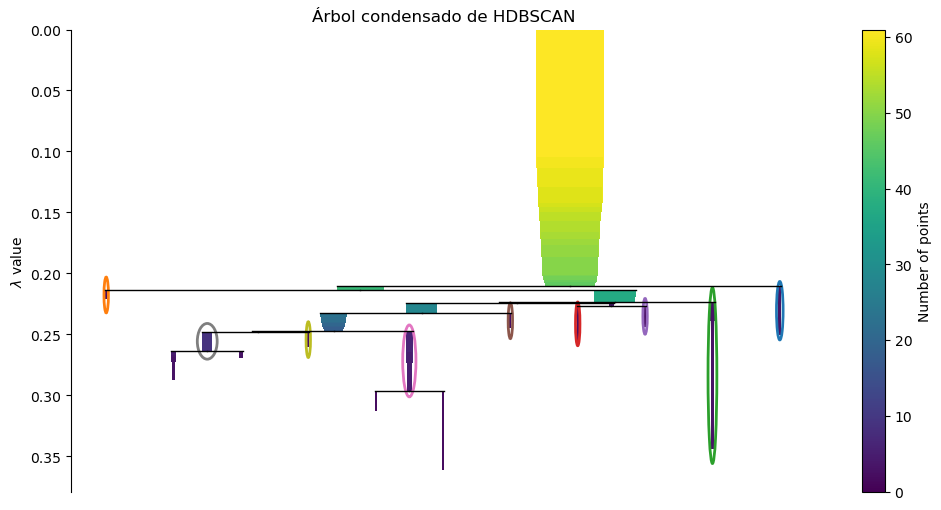

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ya lo tienes entrenado como "hdb"
plt.figure(figsize=(12, 6))
hdb.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.title("Árbol condensado de HDBSCAN")
plt.show()

### Utilizar dendogram

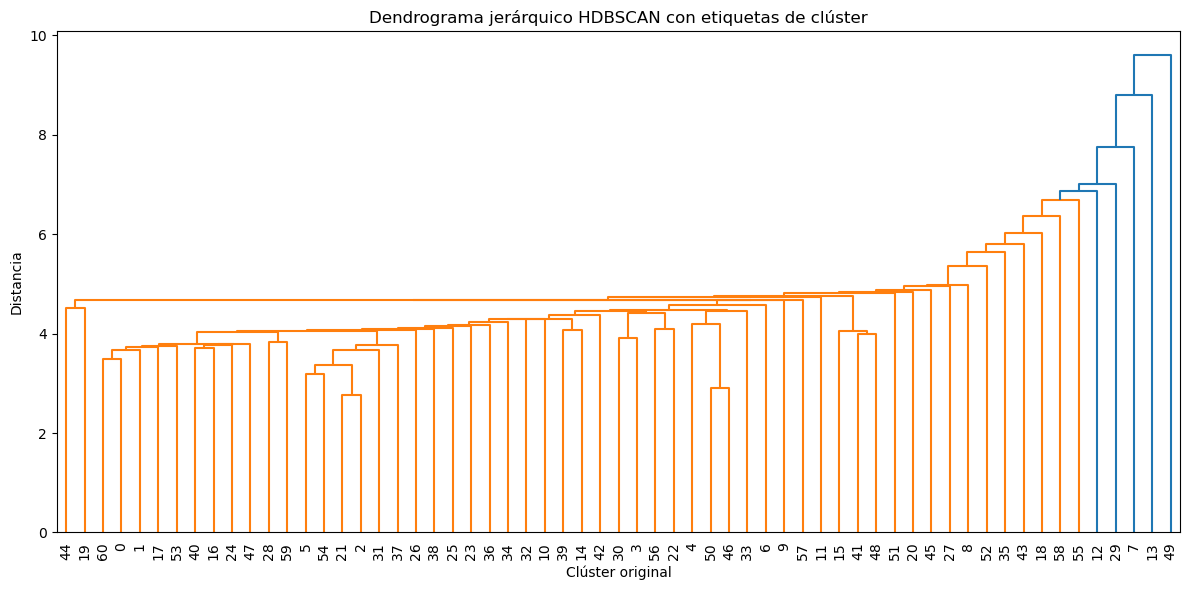

In [9]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import numpy as np

# Paso 1: Obtener la linkage matrix desde HDBSCAN
linkage_matrix = hdb.single_linkage_tree_.to_numpy()

# Paso 2: Obtener los IDs originales de los clústeres (ordenados como en X_cluster_vectors)
cluster_ids_originales = list(vector_clusters.keys())  # ejemplo: [-1, 0, 1, 2, ...]

# Paso 3: Plot del dendrograma con etiquetas
plt.figure(figsize=(12, 6))
dendrogram(
    linkage_matrix,
    labels=[str(cid) for cid in cluster_ids_originales],
    leaf_rotation=90,
    leaf_font_size=10,
)
plt.title("Dendrograma jerárquico HDBSCAN con etiquetas de clúster")
plt.xlabel("Clúster original")
plt.ylabel("Distancia")
plt.tight_layout()
plt.show()


### Mapa  de calor
Para observar mejor el clúster de destino de HDBSCAN

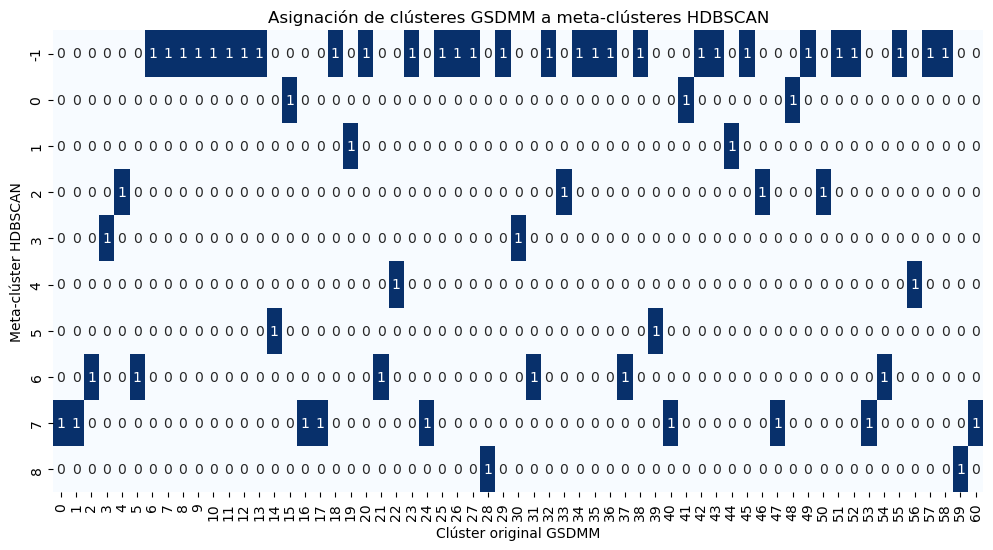

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear DataFrame de asignación
df_asignacion = pd.DataFrame({
    'cluster_gsdmm': cluster_ids_originales,
    'meta_cluster': etiquetas_meta_cluster
})

# Contar
conteo = df_asignacion.groupby(['meta_cluster', 'cluster_gsdmm']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(conteo, annot=True, cmap='Blues', cbar=False)
plt.title("Asignación de clústeres GSDMM a meta-clústeres HDBSCAN")
plt.xlabel("Clúster original GSDMM")
plt.ylabel("Meta-clúster HDBSCAN")
plt.show()